## <a class="anchor" id="head">Social vulnerability and Covid-19 in Chile</a>

[Part I: A first look at the DataFrames](#first-look)

[Part II: Covid-19 in Chile](#part-ii)
    1. Covid-19 in Chile and worldwide
    2. Timeline of Covid-19 cases and deaths in Chile 
    3. Which are the 10 most affected districts in Chile, regarding cases and deaths

[Part III: Analyze the CASEN data: The ten most affected districts](#part-iii)
    1. Correlation between the CASEN social indicators and cases/deaths in the ten most affected districts
    2. Analyze six selected CASEN social indicators for the ten most affected districts
    3. Correlation between six selected CASEN social indicators and cases/deaths for most affected districts

[Part IV: Analyze the CASEN data: The ten less affected districts](#part-iv)
    1. Correlation between the CASEN social indicators and cases/deaths in the ten less affected districts
    2. A closer look at the indicators with the highest correlation for the ten less affected districts 

[Part V: Plot CASEN data vs. Covid-19 cases/deaths](#part-v)
    1. Scatterplot for Covid-19 cases
    2. Scatterplot for Covid-19 deaths

[Part VI: Predict Covid-19 cases/deaths applying a Machine Learning model to CASEN data](#part-vi)

In [68]:
# Read in libraries
import pandas as pd
pd.options.mode.chained_assignment = None  

import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 cases and deaths in Chilean regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True)

deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True)

# Read in data about Covid-19 in Chilean districts
cases_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv')
cases_districts = cases_districts[~cases_districts.Comuna.str.contains('Desconocido')]

deaths_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto38/CasosFallecidosPorComuna.csv')
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Desconocido')]
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Total')]



# Read in data about Covid-19 worldwide
csse_cases_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

csse_all_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-27-2020.csv')

csse_deaths_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [196]:
# Read in World Bank data about population
worldbank_population = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_1217749.csv', skiprows = range(3))
worldbank_population = worldbank_population.iloc[:, [0, 1, -2]]

# Unforunately, the World Bank country names are not in all cases the same as the CSSE country names. Therefore
# some renaming is necessary. 
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('United States', 'US')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Yemen, Rep.', 'Yemen')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Myanmar', 'Burma')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Kitts and Nevis', 'Saint Kitts and Nevis')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Syrian Arab Republic', 'Syria')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Venezuela, RB', 'Venezuela')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Slovak Republic', 'Slovakia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Vincent and the Grenadines', 'Saint Vincent and the Grenadines')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Lucia', 'Saint Lucia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Russian Federation', 'Russia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Kyrgyz Republic', 'Kyrgyzstan')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Korea, Rep.', 'Korea, South')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Iran, Islamic Rep.', 'Iran')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Gambia, The', 'Gambia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Egypt, Arab Rep.', 'Egypt')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Czech Republic', 'Czechia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Congo, Dem. Rep.', 'Congo (Kinshasa)')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Congo, Rep.', 'Congo (Brazzaville)')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Brunei Darussalam', 'Brunei')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Bahamas, The', 'Bahamas')


In [265]:
# Select only 41 relevant indicators from the CASEN study, such as poverty, access to health institutions or
# number of persons in household. 

casen_columns = ['region', 'provincia', 'comuna', 'e1', 'e6a', 'o1', 'o12', 'o16', 'o25a_min',
                'o25c', 'o28', 'y21a', 'y22a', 'y24', 'y27a', 'ysub', 'ytot', 's12', 's13', 's14', 
                's26a', 's27a', 's28', 's31a1', 's33g1', 's33i1', 's33j1',
                'r1a', 'r3', 'r8a', 'r8b', 'r16a', 'r16b', 'v33', 'v37a', 'v37c',
                'v37i', 'v39b', 'pobreza', 'hh_d_prevs', 'hh_d_cot', 'hh_d_servbas', 'qaut', 'numper']

casen_rel = casen[casen_columns]

## <a class="anchor" id="first-look">Part I: A first look at the DataFrames</a>

[Go to index](#head)

A first look at the DataFrames shows that the CASEN data has a lot of NaNs. E.g. the variable s32c ('Do you have difficulties with moving within your house?') has a very high percentage of NaNs. Other possible variables (option 2 and 3 for 'permament conditions'), that I found interesting at first, had more than 97% of NaNs which is why I dropped them.  

Interestingly, other indicators that are about not having enough money to buy food or having a water heater at home have the same share of NaNs, which is 67%. 

In [198]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [199]:
df_list = [casen_rel, cases_regions, deaths_regions, cases_districts, deaths_districts, csse_cases_all, csse_deaths_all]

first_look(df_list)

Information for DataFrame casen_rel
The shape of this DataFrame is (216439, 44).
NaN share for each column:
region          0.000000
provincia       0.000000
comuna          0.000000
e1              0.191107
e6a             0.000000
o1              0.191107
o12             0.573011
o16             0.682913
o25a_min        0.573011
o25c            0.625299
o28             0.191107
y21a            0.615448
y22a            0.000000
y24             0.672203
y27a            0.191107
ysub            0.712524
ytot            0.331424
s12             0.000000
s13             0.000000
s14             0.615448
s26a            0.000000
s27a            0.000000
s28             0.000000
s31a1           0.000000
s33g1           0.191107
s33i1           0.191107
s33j1           0.191107
r1a             0.000000
r3              0.000000
r8a             0.672203
r8b             0.672203
r16a            0.672203
r16b            0.672203
v33             0.000000
v37a            0.000000
v37c            0

Region           0.000000
Codigo region    0.000000
Comuna           0.000000
Codigo comuna    0.000000
Poblacion        0.000000
2020-03-30       0.008671
2020-04-01       0.000000
2020-04-03       0.000000
2020-04-06       0.000000
2020-04-08       0.000000
2020-04-10       0.000000
2020-04-13       0.000000
2020-04-15       0.000000
2020-04-17       0.000000
2020-04-20       0.000000
2020-04-24       0.000000
2020-04-27       0.000000
2020-05-01       0.000000
2020-05-04       0.000000
2020-05-08       0.000000
2020-05-11       0.000000
2020-05-15       0.000000
2020-05-18       0.000000
2020-05-22       0.000000
2020-05-25       0.000000
2020-05-29       0.000000
2020-06-01       0.000000
2020-06-05       0.000000
2020-06-08       0.000000
2020-06-12       0.000000
2020-06-15       0.000000
2020-06-19       0.000000
2020-06-23       0.000000
2020-06-28       0.000000
2020-07-01       0.000000
2020-07-05       0.000000
2020-07-10       0.000000
2020-07-13       0.000000
2020-07-17  

              Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    21.076624   22.829441    2.086466    2.458647    3.537594    5.390977   
std     24.904600   70.191330   27.279200   27.377862   34.083035   47.434934   
min    -51.796300 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.677575  -15.277675    0.000000    0.000000    0.000000    0.000000   
50%     22.820850   20.921188    0.000000    0.000000    0.000000    0.000000   
75%     41.143200   77.913685    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20  ...       7/29/20  \
count   266.000000   266.000000   266.000000   266.000000  ...  2.660000e+02   
mean      7.962406    11.003759    20.969925    23.180451  ...  6.401938e+04   
std      66.289178    89.31375

## <a class="anchor" id="part-ii">Part II: Covid-19 in Chile</a>

[Go to index](#head)

###     A. Covid-19 in Chile and worldwide

First, lets have a look at the spread of Covid-19 in Chile and worldwide. Therefore, we compare the number of cases and deaths per 100.000 habitants. 

In [200]:
def plot_covid_worldwide(df, title, country, m, z=100000, t=100000):
    """
    Function to plot a comparison between the m-most affected countries (as per z habitants) 
    and a specific country, which is highlighted in red. 
    
    If the specific country is not wihtin the m-most affected countries, it is appended at the end. 
    
    Input: 
        df (DataFrame): DataFrame with country data
        title (string): Specify the kind of the plot (cases or deaths) 
        country (string): The country that sould be highlighted
        m (int): Returns the m-most affected countries. 
        z (int): Number to calculate the cases per z habitants
        t (int): Number of minimal population for a country to be considered (standard: 100.000)
        
    Output: 
        A seaborn plot. 
    """
    
    # Get the relevant columns of df (Countryname and total number) and add a new column
    # of cases/deaths per z habitants. Rename the columns. 
    df_current = df.iloc[:, [1, -1]]
    df_current.columns = ['Country', title]

    # Merge World Bank population data with DataFrame
    df_final = df_current.merge(worldbank_population, left_on = 'Country', right_on = 'Country Name', how = 'left')
    df_final = df_final.drop(['Country Name', 'Country Code'], axis = 1)
    df_final.columns = ['Country', title, 'population']

    # Calculate cases per z habitants
    df_final.loc[:, 'per {} habitants'.format(z)] = (df_final.loc[:, title] / df_final.loc[:, 'population']) * z

    # Drop rows of countries that are below z
    rows_to_drop = []

    for i in range(len(df_final.population)):
        if df_final.population[i] < t:
            rows_to_drop.append(i)

    df_final = df_final.drop(rows_to_drop, axis = 0)


    # Groupby country and get the m-most affected countries. 
    df_final = df_final.groupby(
        'Country')[
        'per {} habitants'.format(z)].sum().reset_index().sort_values([
        'per {} habitants'.format(z)], ascending = False)
    
    # Show only the top m countries
    df_final_head = df_final.head(m)

    # Check if specific country is part of the m-most affected countries
    if country in list(df_final_head.Country) == True:

        # Get index of specific country in country list
        index = list(df_final_head.Country).index(country)

        # Plot the figure
        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_final_head['Country'], x = df_final_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per {} habitants'.format(title, z), fontsize = 12)
        plt.title('Covid-19 {} per {} habitants worldwide'.format(title, z), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()


    # If the specific country is not within the m-most affected countries, append it to the list
    else:

        df_final_head = df_final_head.append(df_final[df_final['Country'] == country])
        index = list(df_final_head.Country).index(country)

        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_final_head['Country'], x = df_final_head['per {} habitants'.format(z)], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per {} habitants'.format(title, z), fontsize = 12)
        plt.title('Covid-19 {} per {} habitants worldwide'.format(title, z), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()

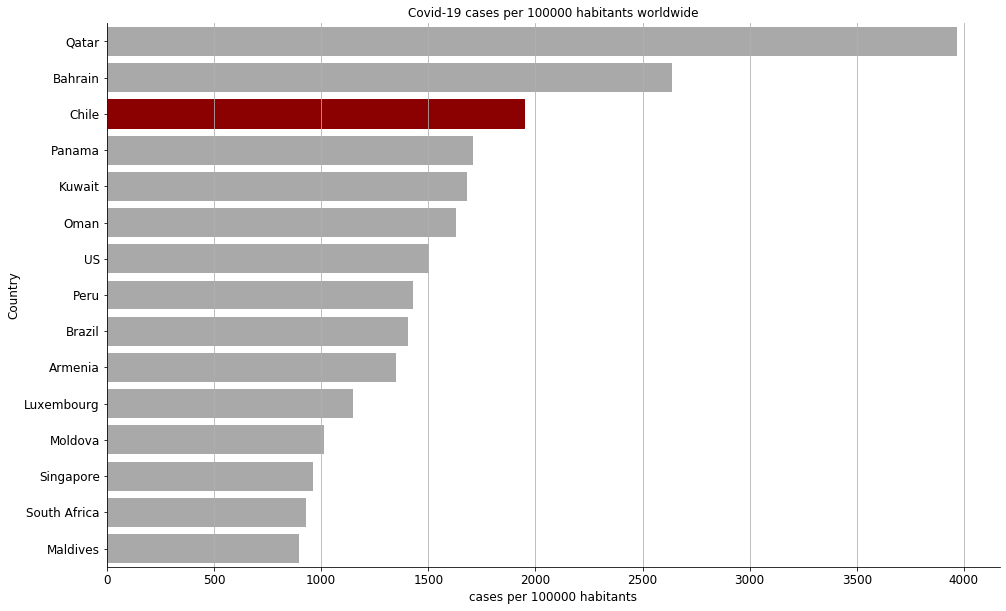

In [201]:
plot_covid_worldwide(csse_cases_all, 'cases', 'Chile', 15, 100000, 100000)

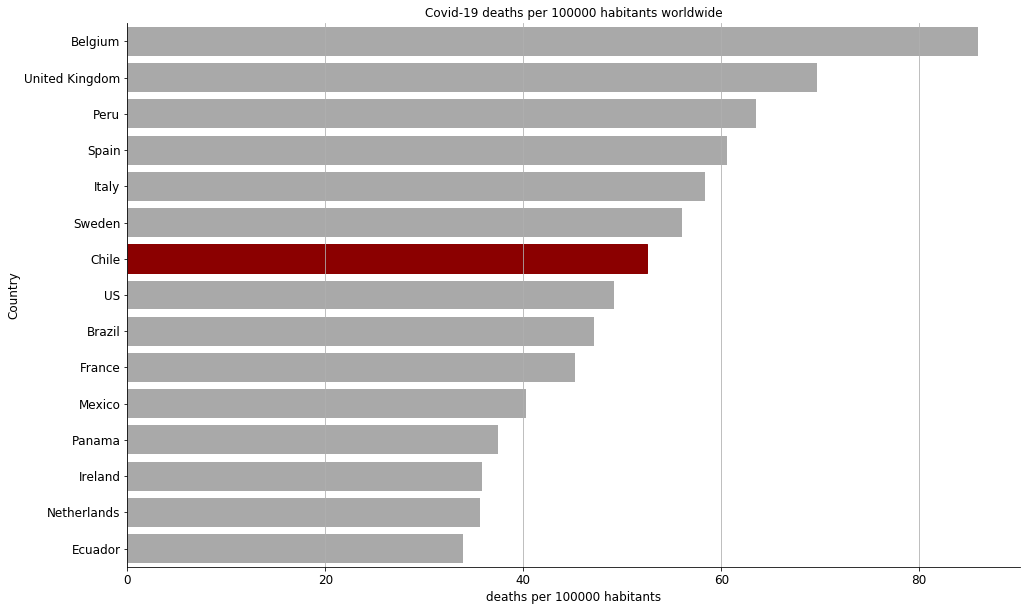

In [202]:
plot_covid_worldwide(csse_deaths_all, 'deaths', 'Chile', 15, 100000, 100000)

### B. Timeline of Covid-19 cases and deaths in Chile 

Next, we will focus on the situation in Chile. Chile is separated into 16 different regions, where "Metropolitana" is the region where the capital Santiago de Chile is located. It becomes clear that the Metropolitan Region is by far most affected by Covid-19.

However, other regions, just like Valparaíso (close to Santiago) and Antofagasta (in the north) experienced a very high rise in cases and deaths. 

In [203]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): A transposed DataFrame where the first row (not the index) is the date and the columns are the 
        regions. 
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('{}'.format(title), fontsize = 12)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 12)
    
    plt.tick_params(labelsize=12)
    ax.yaxis.tick_right()
    ax.set_yscale('log')


    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()
            

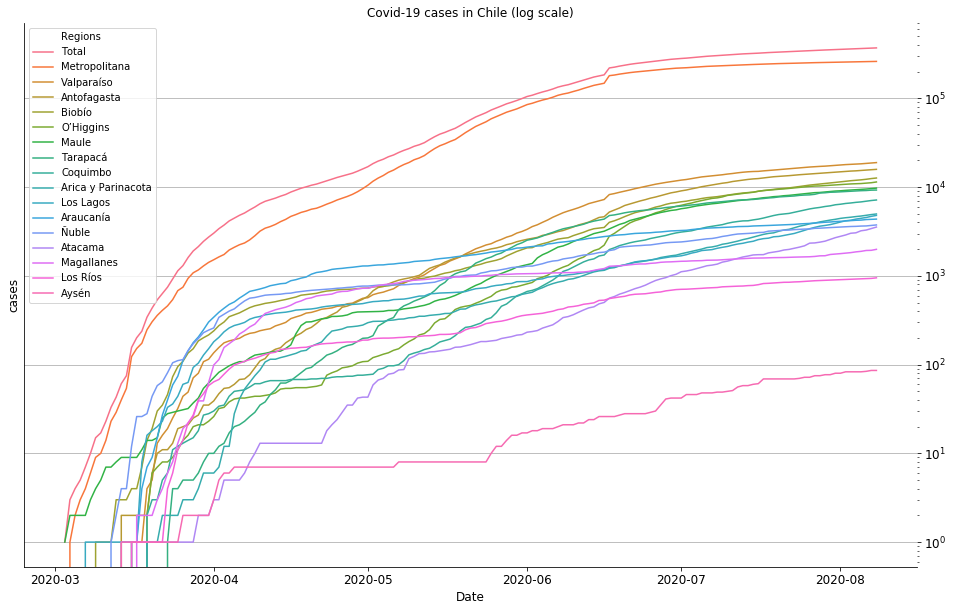

In [204]:
timeline_plot(cases_regions, 'cases')

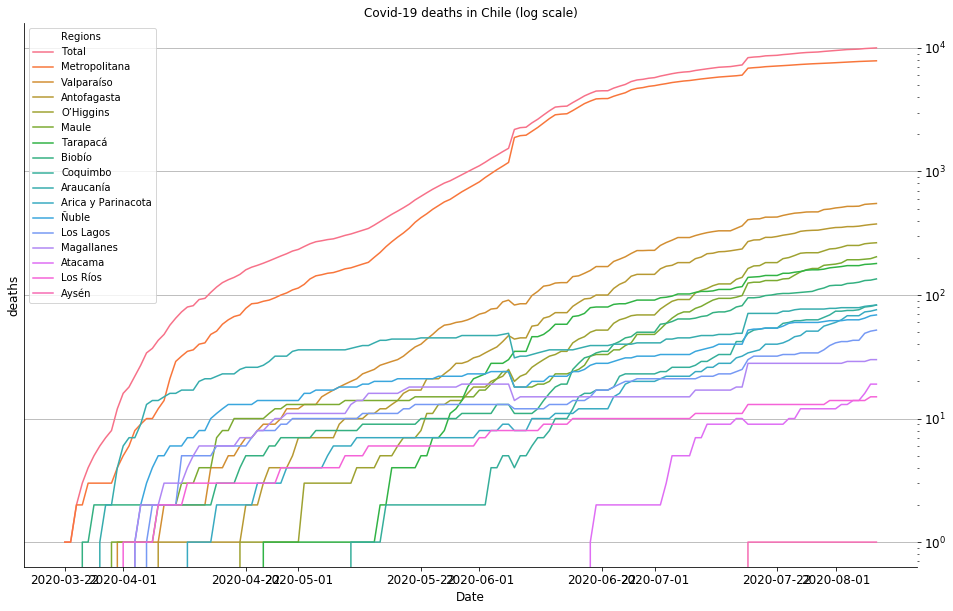

In [205]:
timeline_plot(deaths_regions, 'deaths')

###     B. Which are the 10 most affected districts in Chile, regarding cases and deaths

Looking at the most affected districts in Chile, it is no surprise that they are mainly located in the capital metropolitan zone. 

In [206]:
def get_affected_districts(df, title, m, n=100):
    """
    Function to get the m most or less affected districts. If m is negative, it returns the 10 less affected
    districts. Given that there are still some remote Chilean districts with 0 or only a few Covid-19 cases
    (Antarctic, Easter Islands), I chose a threshold of minimum n cases/deaths to be considered. 
    
    Input: 
        df (DataFrame): DataFrame with information about districts and numbers of cases/deaths
        title (string): Specify the kind of the data (cases or deaths)
        m (int): Returns the m most affected districts, if m is postitive and the m less affected districts
                 if m is negative. If m == 0, it returns a sorted DataFrame of all districts.
        n (int): Threshold of minimum number of cases/deaths 
        
    Output:
        affected (DataFrame): DataFrame with the m most or less affected districts
    """

    # Get the relevant columns from dataframe and rename them
    df_relevant = df.iloc[:, [0, 2, 3, -2]]
    df_relevant.columns = ['Region', 'District', 'District ID', title]
    
    # If m is positive, return the most affected districts. If m is negative, return the less affected districts.
    # If m == 0, return the whole list. 
    
    if m > 0:    
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).head(m).reset_index()

        affected = affected.drop(['index'], axis = 1)  

    if m < 0:
        
        # Consider only the districts with more than 10 cases/deaths: 
        df_relevant = df_relevant[df_relevant[df_relevant.columns[-1]] >= n]
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).tail(m*(-1)).reset_index()

        affected = affected.drop(['index'], axis = 1)  
    
    if m == 0: 
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).reset_index()

        affected = affected.drop(['index'], axis = 1)  
        
        
    return affected

In [207]:
get_affected_districts(cases_districts, 'cases', 10, 100)

,District,Region,District ID,cases
0,Puente Alto,Metropolitana,13201.0,22824.0
1,Santiago,Metropolitana,13101.0,14741.0
2,Maipu,Metropolitana,13119.0,14411.0
3,La Florida,Metropolitana,13110.0,13500.0
4,Penalolen,Metropolitana,13122.0,11673.0
5,San Bernardo,Metropolitana,13401.0,11027.0
6,La Pintana,Metropolitana,13112.0,10118.0
7,Pudahuel,Metropolitana,13124.0,9665.0
8,Quilicura,Metropolitana,13125.0,9005.0
9,Renca,Metropolitana,13128.0,8384.0


In [208]:
get_affected_districts(deaths_districts, 'deaths', 10, 100)

,District,Region,District ID,deaths
0,Puente Alto,Metropolitana,13201.0,542.0
1,La Florida,Metropolitana,13110.0,451.0
2,Maipu,Metropolitana,13119.0,370.0
3,San Bernardo,Metropolitana,13401.0,317.0
4,Penalolen,Metropolitana,13122.0,306.0
5,La Pintana,Metropolitana,13112.0,304.0
6,Recoleta,Metropolitana,13127.0,298.0
7,Las Condes,Metropolitana,13114.0,281.0
8,Santiago,Metropolitana,13101.0,277.0
9,Cerro Navia,Metropolitana,13103.0,242.0


In [209]:
# Save data about cases and deaths:
cases_districts_csv = get_affected_districts(cases_districts, 'cases', 10, 100)
cases_districts_csv.to_csv('./Media/cases_districts.csv')

deaths_districts_csv = get_affected_districts(deaths_districts, 'deaths', 10, 100)
deaths_districts_csv.to_csv('./Media/deaths_districts.csv')


## <a class="anchor" id="part-iii">Part III: Analyze the CASEN data</a>
 
[Go to index](#head)
 
### A. A first approach with the CASEN social indicators for the ten most affected districts regarding Covid-19 cases

In a next step, we are going to analyze the correlation between the CASEN data about social vulnerability and Covid-19 cases and deaths in the most affected districts in Chile. 

In our first approach with take the (already long) short list of 46 CASEN indicators and look at their correlation with Covid-19 cases and deaths. 

In [210]:
def show_CASEN_for_districts(df, casen_data, title, m, n): 
    """
    A function to merge a DataFrame with the CASEN data and return an DataFrame with the mean of 
    the different CASEN indicators and the m most affected districts. 
    
    Input: 
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered. 
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districts, if m is postitive and the m less affected districts
                 if m is negative. If m == 0, it returns a sorted DataFrame of all districts.
        
    Output: 
        casen_district_grouped (DataFrame): DataFrame with the mean values of the CASEN indicators for the 
        m most affected districts, sorted by the number of cases/deaths. 
        
    """

    # Store 10 most affected districts (cases) in list: 
    top_districts = get_affected_districts(df, title, m, n)
    districts_list = list(top_districts['District ID'])

    # Filter casen_rel DataFrame so it contains only the 10 most affected districts: 
    casen_district = casen_data[casen_data.comuna.isin(districts_list) == True]

    # Return mean value for each indicator
    casen_district_grouped = casen_district.groupby(['comuna'])[[i for i in casen_district.columns[3:]]].mean().reset_index()

    # Merge with data about most affected districts, drop District ID column and sort by cases or deaths
    casen_district_grouped = casen_district_grouped.merge(top_districts, left_on = 'comuna', right_on = 'District ID', how = 'left')
    casen_district_grouped = casen_district_grouped.drop(['District ID'], axis = 1).sort_values(title, ascending = False)
    
    return casen_district_grouped


In [211]:
show_CASEN_for_districts(cases_districts, casen_rel, 'cases', 10, 100)

,comuna,e1,e6a,o1,o12,o16,o25a_min,o25c,o28,y21a,...,v39b,pobreza,hh_d_prevs,hh_d_cot,hh_d_servbas,qaut,numper,District,Region,cases
8,13201,1.038925,9.412603,1.423246,1.513926,1.247863,17.544474,1.553936,1.400219,4.898007,...,1.914976,2.899827,0.071893,0.397575,0.009499,2.971071,4.036269,Puente Alto,Metropolitana,22824.0
0,13101,1.031286,11.087912,1.298635,1.268716,1.222744,19.832151,1.845106,1.465870,4.972782,...,2.137602,2.929220,0.112669,0.262295,0.028694,3.781444,3.078431,Santiago,Metropolitana,14741.0
3,13119,1.040534,9.713341,1.455412,1.262719,1.168317,18.160967,1.563603,1.619456,4.894624,...,1.515364,2.966161,0.092960,0.369976,0.007779,3.122131,3.963827,Maipu,Metropolitana,14411.0
1,13110,1.088595,9.823140,1.442464,1.546889,1.224256,17.694128,1.564752,1.441446,4.891429,...,1.548347,2.941322,0.080579,0.386097,0.014876,3.189256,4.136364,La Florida,Metropolitana,13500.0
4,13122,1.074513,9.583676,1.431837,1.442693,1.233397,18.180516,1.613105,1.536833,4.575472,...,1.696845,2.943681,0.083276,0.431512,0.029533,3.257555,4.354396,Penalolen,Metropolitana,11673.0
9,13401,1.080131,8.694073,1.469338,1.473607,1.255725,17.697947,1.650696,1.372036,4.797639,...,2.152964,2.878904,0.059730,0.358009,0.036966,2.625876,4.408540,San Bernardo,Metropolitana,11027.0
2,13112,1.147757,8.107287,1.480211,1.874396,1.366300,15.567633,1.518717,1.455145,4.679525,...,2.474696,2.802632,0.049595,0.504082,0.016194,2.305668,4.263158,La Pintana,Metropolitana,10118.0
5,13124,1.086667,9.209626,1.426667,1.358407,1.201220,15.743363,1.526185,1.580000,4.860465,...,1.914439,2.887701,0.096257,0.412214,0.007487,2.925134,4.150802,Pudahuel,Metropolitana,9665.0
6,13125,1.033486,8.596450,1.415525,1.161954,1.184300,16.434447,1.758904,1.321157,4.858065,...,2.074556,2.904142,0.049704,0.259172,0.035503,3.036686,3.970414,Quilicura,Metropolitana,9005.0
7,13128,1.120209,8.716253,1.432056,1.565598,1.319392,17.413994,1.671053,1.486063,4.832143,...,1.874656,2.942149,0.051318,0.398340,0.008264,2.841598,4.388430,Renca,Metropolitana,8384.0


In [212]:
show_CASEN_for_districts(deaths_districts, casen_rel, 'deaths', 10, 100)

,comuna,e1,e6a,o1,o12,o16,o25a_min,o25c,o28,y21a,...,v39b,pobreza,hh_d_prevs,hh_d_cot,hh_d_servbas,qaut,numper,District,Region,deaths
8,13201,1.038925,9.412603,1.423246,1.513926,1.247863,17.544474,1.553936,1.400219,4.898007,...,1.914976,2.899827,0.071893,0.397575,0.009499,2.971071,4.036269,Puente Alto,Metropolitana,542.0
2,13110,1.088595,9.823140,1.442464,1.546889,1.224256,17.694128,1.564752,1.441446,4.891429,...,1.548347,2.941322,0.080579,0.386097,0.014876,3.189256,4.136364,La Florida,Metropolitana,451.0
5,13119,1.040534,9.713341,1.455412,1.262719,1.168317,18.160967,1.563603,1.619456,4.894624,...,1.515364,2.966161,0.092960,0.369976,0.007779,3.122131,3.963827,Maipu,Metropolitana,370.0
9,13401,1.080131,8.694073,1.469338,1.473607,1.255725,17.697947,1.650696,1.372036,4.797639,...,2.152964,2.878904,0.059730,0.358009,0.036966,2.625876,4.408540,San Bernardo,Metropolitana,317.0
6,13122,1.074513,9.583676,1.431837,1.442693,1.233397,18.180516,1.613105,1.536833,4.575472,...,1.696845,2.943681,0.083276,0.431512,0.029533,3.257555,4.354396,Penalolen,Metropolitana,306.0
3,13112,1.147757,8.107287,1.480211,1.874396,1.366300,15.567633,1.518717,1.455145,4.679525,...,2.474696,2.802632,0.049595,0.504082,0.016194,2.305668,4.263158,La Pintana,Metropolitana,304.0
7,13127,1.107143,9.139140,1.476648,1.249370,1.167785,15.891688,1.755747,1.245879,4.924581,...,1.816742,2.918552,0.097285,0.328409,0.031674,2.955882,3.520362,Recoleta,Metropolitana,298.0
4,13114,1.023915,12.064947,1.426029,1.222120,1.154545,18.756682,1.868308,1.516129,5.114548,...,1.715339,2.996248,0.023932,0.199525,0.020686,4.492495,3.594747,Las Condes,Metropolitana,281.0
0,13101,1.031286,11.087912,1.298635,1.268716,1.222744,19.832151,1.845106,1.465870,4.972782,...,2.137602,2.929220,0.112669,0.262295,0.028694,3.781444,3.078431,Santiago,Metropolitana,277.0
1,13103,1.078040,9.132653,1.444646,1.591640,1.322581,14.382637,1.610294,1.578947,4.794007,...,1.895044,2.909621,0.183673,0.446903,0.037901,2.588921,4.483965,Cerro Navia,Metropolitana,242.0


In [213]:
def show_corr(df, casen_data, title, m, n): 
    """
    Function to show the correlation between CASEN data and the number of Covid-19 cases/deaths
    in the m most affected districts. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered. 
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districts, if m is postitive and the m less affected districts
                 if m is negative. If m == 0, it returns a sorted DataFrame of all districts.

    Output: 
        corr (Series): Sorted pandas series that shows the correlation between Covid-19 cases/deaths
        and the different CASEN indicators. 
    """

    # Get CASEN data for m most affected districts and drop the columns that are not need
    top_10_corr = show_CASEN_for_districts(df, casen_rel, title, m, n)
    corr_data = top_10_corr.drop(['comuna', 'District', 'Region', title], axis = 1)

    # Sort values from highest correlation to lowest
    corr = top_10_corr.corrwith(top_10_corr[title]).sort_values(ascending = False)
    
    return corr

In [266]:
show_corr(cases_districts, casen_rel, 'cases', 10, 100).head()

cases       1.000000
e6a         0.470221
o25a_min    0.414659
v37c        0.391279
y21a        0.365578
dtype: float64

In [215]:
show_corr(deaths_districts, casen_rel, 'deaths', 10, 100).head()

deaths    1.000000
v37i      0.403584
s26a      0.264591
y27a      0.216416
y24       0.206331
dtype: float64

In [216]:
# Save as csv

corr_cases_most_csv = show_corr(cases_districts, casen_rel, 'cases', 10, 100)
corr_cases_most_csv.to_csv('./Media/corr_cases_most.csv', header = True)

deaths_districts_csv = show_corr(deaths_districts, casen_rel, 'deaths', 10, 100)
deaths_districts_csv.to_csv('./Media/corr_deaths_most.csv', header = True)

In [217]:
# Get the top3 indicators with the highest correlation and add comuna, s12 and numper:
top3_list_cases = list(show_corr(cases_districts, casen_rel, 'cases', 10, 100).index[1:4])
top3_list_deaths = list(show_corr(deaths_districts, casen_rel, 'deaths', 10, 100).index[1:4])

list_total = ['comuna'] + top3_list_cases + top3_list_deaths + ['s12'] + ['numper']
list_total

['comuna', 'e6a', 'o25a_min', 'v37c', 'v37i', 's26a', 'y27a', 's12', 'numper']

In [218]:
# Lets focus on the three CASEN indicators, that showed the highest correlation with Covid-19 cases and deaths
# in Chile: 
casen_rel_in = casen_rel[list_total]

### B. Analyze selected CASEN social indicators for the ten most affected districts regarding Covid-19 cases 

Now we have some CASEN indicators - interestingly not the same - that have the highest correlation with Covid-19 cases and deaths in Chile.

In [219]:
# Lets look again at the selected indicators:  
first_look([casen_rel_in])

Information for DataFrame casen_rel_in
The shape of this DataFrame is (216439, 9).
NaN share for each column:
comuna      0.000000
e6a         0.000000
o25a_min    0.573011
v37c        0.000000
v37i        0.000000
s26a        0.000000
y27a        0.191107
s12         0.000000
numper      0.000961
dtype: float64
Describe() for each column:
              comuna            e6a      o25a_min           v37c  \
count  216439.000000  216439.000000  92417.000000  216439.000000   
mean     9004.354456       9.121923     16.794518       1.224909   
std      4181.203296       5.804464     14.943926       0.621265   
min      1101.000000       1.000000      0.000000       1.000000   
25%      5804.000000       7.000000      1.000000       1.000000   
50%      9101.000000       9.000000     15.000000       1.000000   
75%     13115.000000      11.000000     30.000000       1.000000   
max     16305.000000      99.000000     99.000000       9.000000   

                v37i           s26a          

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BD0D6952E8>,
      dtype=object)

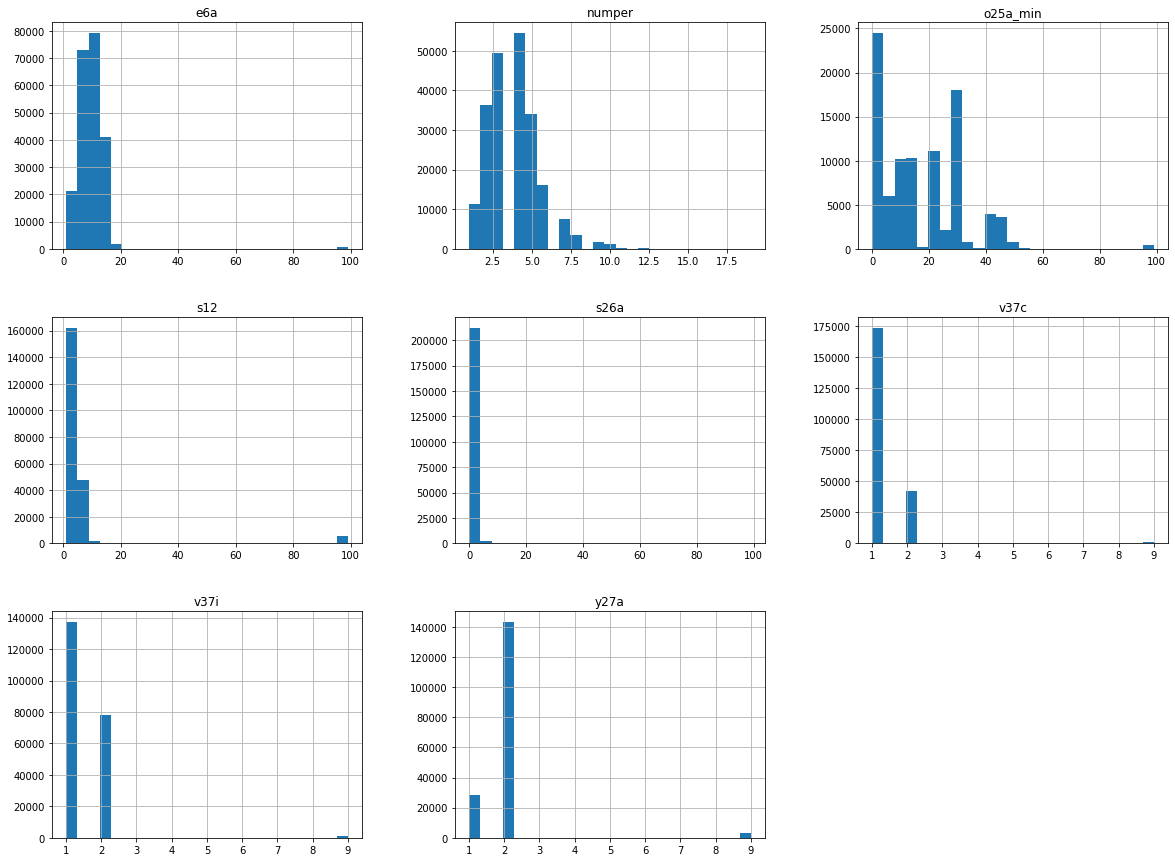

In [220]:
casen_rel_in.drop(['comuna'], axis = 1).hist(figsize = (20, 15), bins = 25)

16.794518324550676


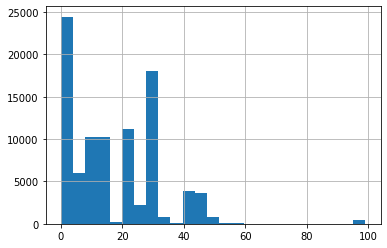

In [221]:
# The column o25a_min has a lot of NaNs, the mean commuting time is about 16 minutes. 
print(casen_rel_in['o25a_min'].mean())

casen_rel_in['o25a_min'].hist(bins = 25)

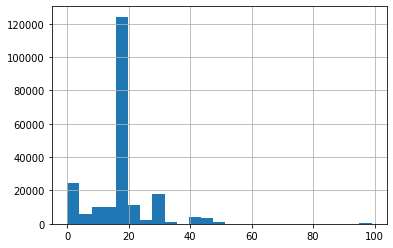

In [222]:
# Given that the NaNs could change the correlation, we fill them with the mean of the column. 
casen_rel_in['o25a_min'] = casen_rel_in['o25a_min'].fillna(casen_rel_in['o25a_min'].mean())

casen_rel_in['o25a_min'].hist(bins = 25)

AxesSubplot(0.125,0.125;0.775x0.755)


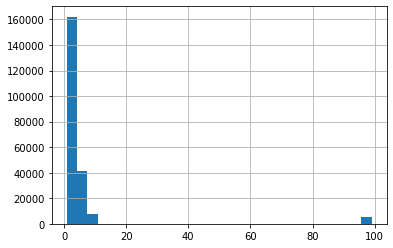

In [223]:
# The s12 column is also a very interesting case. It contains values between 1 and 7, where 1 is the 
# most basic health insurance system and 7 the most extensive system. However, 8 (no health insurance) and 9 
# (other system) do not provide more services than number 7, so its no continuous scale. 
print(casen_rel_in['s12'].hist(bins = 30))

In [224]:
# We have to add therefore more columns following the one hot encoding approach.
# With the get_dummies method, we can create some dummy columns for the different health insurance systems: 
casen_rel_most = pd.concat([casen_rel_in, pd.get_dummies(casen_rel_in['s12'])], axis = 1).drop(['s12'], axis = 1)

casen_rel_most.head()

,comuna,e6a,o25a_min,v37c,v37i,s26a,y27a,numper,1,2,3,4,5,6,7,8,9,99
0,1101,9,10.0,1,1,5,2.0,1.0,0,0,0,0,0,0,0,0,0,1
1,1101,7,10.0,2,2,0,2.0,1.0,0,0,0,0,0,0,0,1,0,0
2,1101,9,10.0,2,1,0,9.0,2.0,0,0,0,0,0,0,0,0,0,1
3,1101,9,10.0,2,1,0,9.0,2.0,0,0,0,0,0,0,0,0,0,1
4,1101,13,40.0,2,1,1,9.0,3.0,0,1,0,0,0,0,0,0,0,0


### C. Show correlation between six selected CASEN social indicators and cases/deaths for most affected districts regarding Covid-19 cases 

Now that we have the DataFrame with the prepared data (filled in the NaNs with o25a_min and one hot encoding for the health insurance system, we can call again the functions to show the correlations between those indicators and the Covid-19 cases/deaths in Chile. 

In [259]:
show_corr(cases_districts, casen_rel_most, 'cases', 10, 100).head()

cases       1.000000
e6a         0.470221
o25a_min    0.414659
v37c        0.391279
y21a        0.365578
dtype: float64

In [260]:
show_corr(deaths_districts, casen_rel_most, 'deaths', 10, 100).head()

deaths    1.000000
v37i      0.403584
s26a      0.264591
y27a      0.216416
y24       0.206331
dtype: float64

## <a class="anchor" id="part-iv">Part IV: Analyze the CASEN data: The ten less affected districts</a>

[Go to index](#head)

### A. Correlation between the CASEN social indicators and cases/deaths in the ten less affected districts

After a look at the ten most affected districts, we will take a look at the ten less affected districts and which are the CASEN indicators with the highest correlation. 

In [227]:
get_affected_districts(cases_districts, 'cases', -10, 100)

,District,Region,District ID,cases
0,El Carmen,Ñuble,16104.0,108.0
1,Villarrica,Araucanía,9120.0,107.0
2,La Union,Los Ríos,14201.0,106.0
3,Caldera,Atacama,3102.0,106.0
4,Pitrufquen,Araucanía,9114.0,105.0
5,Pemuco,Ñuble,16105.0,104.0
6,Sagrada Familia,Maule,7307.0,104.0
7,Maullin,Los Lagos,10108.0,104.0
8,Purranque,Los Lagos,10303.0,103.0
9,Nancagua,O’Higgins,6305.0,101.0


In [241]:
get_affected_districts(deaths_districts, 'deaths', -10, 20)

,District,Region,District ID,deaths
0,San Antonio,Valparaiso,5601.0,37.0
1,Talca,Maule,7101.0,35.0
2,Punta Arenas,Magallanes y la Antartica,12101.0,29.0
3,Concepcion,Biobio,8101.0,29.0
4,San Felipe,Valparaiso,5701.0,28.0
5,Pirque,Metropolitana,13202.0,27.0
6,Temuco,La Araucania,9101.0,25.0
7,Ovalle,Coquimbo,4301.0,21.0
8,La Serena,Coquimbo,4101.0,21.0
9,Rengo,Del Libertador General Bernardo O’Higgins,6115.0,21.0


In [261]:
show_corr(cases_districts, casen_rel, 'cases', -10, 100).head()

cases       1.000000
e6a         0.565274
v37c        0.407054
s12         0.383161
hh_d_cot    0.342066
dtype: float64

In [262]:
show_corr(deaths_districts, casen_rel, 'deaths', -10, 20).head()

deaths    1.000000
s33i1     0.550371
y24       0.502482
s33g1     0.409020
s13       0.296627
dtype: float64

In [246]:
# Get the top3 indicators with the highest correlation and add comuna, s12 and numper:
top3_list_cases_less = list(show_corr(cases_districts, casen_rel, 'cases', -10, 100).index[1:4])
top3_list_deaths_less = list(show_corr(deaths_districts, casen_rel, 'deaths', -10, 20).index[1:4])

list_total_less = ['comuna'] + top3_list_cases_less + top3_list_deaths_less
list_total_less

['comuna', 'e6a', 'v37c', 's12', 's33i1', 'y24', 's33g1']

### B. A closer look at the indicators with the highest correlation for the ten less affected districts

We have now the indicators that have the highest correlation with less Covid-19 cases/deaths in Chile.

In [247]:
casen_rel_less = casen_rel[list_total_less]

print(first_look([casen_rel_less]))

Information for DataFrame casen_rel_less
The shape of this DataFrame is (216439, 7).
NaN share for each column:
comuna    0.000000
e6a       0.000000
v37c      0.000000
s12       0.000000
s33i1     0.191107
y24       0.672203
s33g1     0.191107
dtype: float64
Describe() for each column:
              comuna            e6a           v37c            s12  \
count  216439.000000  216439.000000  216439.000000  216439.000000   
mean     9004.354456       9.121923       1.224909       5.449716   
std      4181.203296       5.804464       0.621265      14.829401   
min      1101.000000       1.000000       1.000000       1.000000   
25%      5804.000000       7.000000       1.000000       2.000000   
50%      9101.000000       9.000000       1.000000       2.000000   
75%     13115.000000      11.000000       1.000000       5.000000   
max     16305.000000      99.000000       9.000000      99.000000   

               s33i1           y24          s33g1  
count  175076.000000  70948.000000  17

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BD02CCCC88>,
      dtype=object)

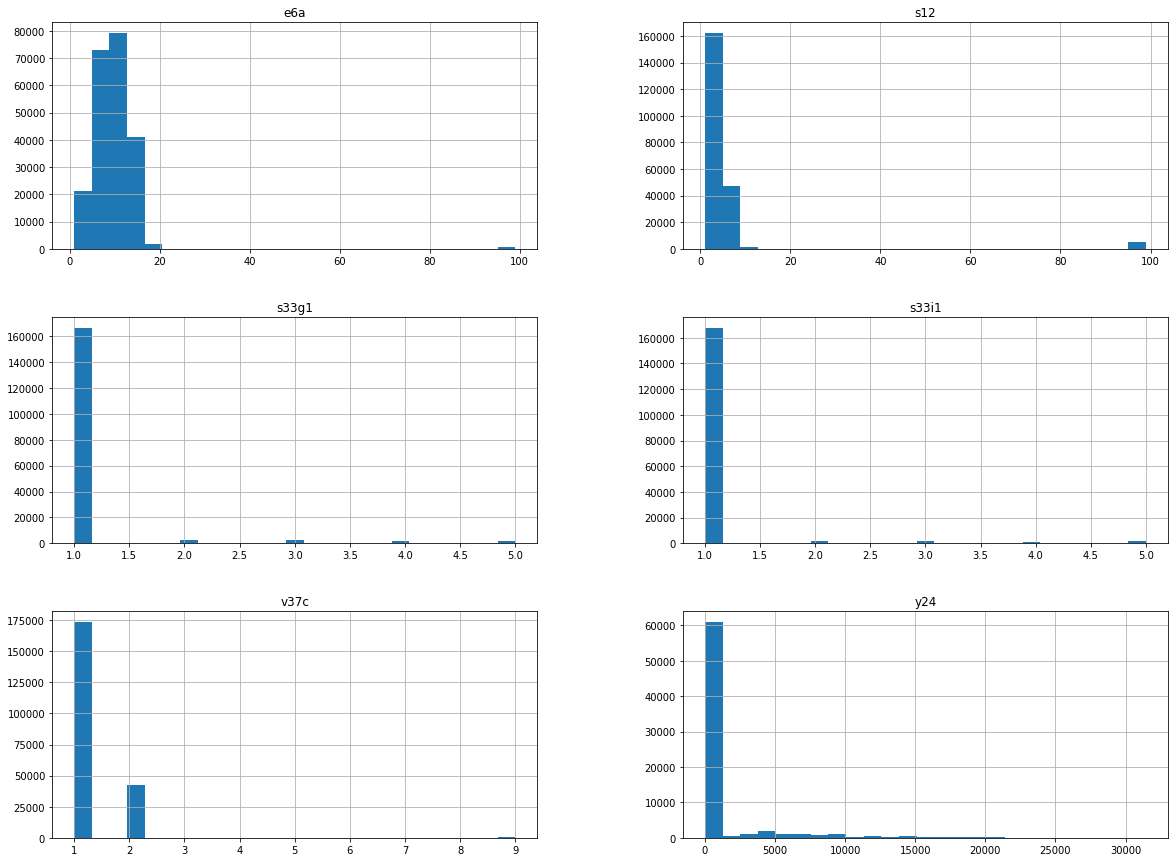

In [249]:
casen_rel_less.drop(['comuna'], axis = 1).hist(figsize = (20, 15), bins = 25)

## <a class="anchor" id="part-v">Part V: Plot CASEN data vs. Covid-19 cases/deaths</a>

[Go to index](#head)

In this chapter, I would like to visualize the correlation between the cases/deaths of Covid-19 in Chile and selected CASEN social indicators. 

In [252]:
# First, we define a new DataFrame that includes the indicators with the 
# highest correlation for the 10 most and the 10 less affected districts. 

casen_rel_all = pd.concat([casen_rel_most, casen_rel_less], axis = 1)

# Get rid of duplicated columns:
casen_rel_all = casen_rel_all.loc[:,~casen_rel_all.columns.duplicated()]

casen_rel_all.head()

,comuna,e6a,o25a_min,v37c,v37i,s26a,y27a,numper,1,2,...,5,6,7,8,9,99,s12,s33i1,y24,s33g1
0,1101,9,10.0,1,1,5,2.0,1.0,0,0,...,0,0,0,0,0,1,99,1.0,0.0,1.0
1,1101,7,10.0,2,2,0,2.0,1.0,0,0,...,0,0,0,1,0,0,8,1.0,0.0,1.0
2,1101,9,10.0,2,1,0,9.0,2.0,0,0,...,0,0,0,0,0,1,99,1.0,0.0,1.0
3,1101,9,10.0,2,1,0,9.0,2.0,0,0,...,0,0,0,0,0,1,99,1.0,NaN,1.0
4,1101,13,40.0,2,1,1,9.0,3.0,0,1,...,0,0,0,0,0,0,2,1.0,0.0,1.0


### A. Scatterplot for Covid-19 cases

In [253]:
def plot_indicator_vs_affected(df, casen_data, title, m, m_2, n):
    """
    A function to plot a scatterplot of the number of cases/deaths of Covid-19 vs. a specific
    CASEN indicator. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districtse. If m == 0, it returns a sorted DataFrame of all districts.
        m_2 (int): Number of how many less affected districts you would like to have returned. 
                   If m == 0, it returns a sorted DataFrame of all districts.
        n: Threshold of number of cases/deaths for districts to be considered in the less affected districts
        
    Output:
        Seaborn subplots of cases vs. specific indicator. 
    
    """
    
    # Prepare one DataFrame with the 10 most and the 10 less affected districts
    df_plot = pd.concat([show_CASEN_for_districts(df, casen_data, title, m, n), 
                                show_CASEN_for_districts(df, casen_rel_all, title, m_2, n)], 
                              axis = 0).reset_index().drop(['index'], axis = 1)

    # Prepare figure
    fig = plt.figure(figsize = (10, 130))

    for item, i in zip(df_plot.columns, range(17)):
        
        # No scatterplot is needed for these categories
        if item not in ['comuna', 'District', 'Region', 'cases', '99']:

            # Add subplot at specific postition
            ax = fig.add_subplot(16, 1, i)

            # Plot the scatterplot
            sns.scatterplot(x = df_plot[item], y = df_plot[title], sizes = (150, 600), size = df_plot[title], hue = df_plot['Region'])
            plt.title('Scatterplot for {} vs. indicator: {}'.format(title, item))
            plt.ylabel(title)
            plt.xlabel('Indicator: {}'.format(item))
            ax.yaxis.grid()
            sns.despine()
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    plt.show()

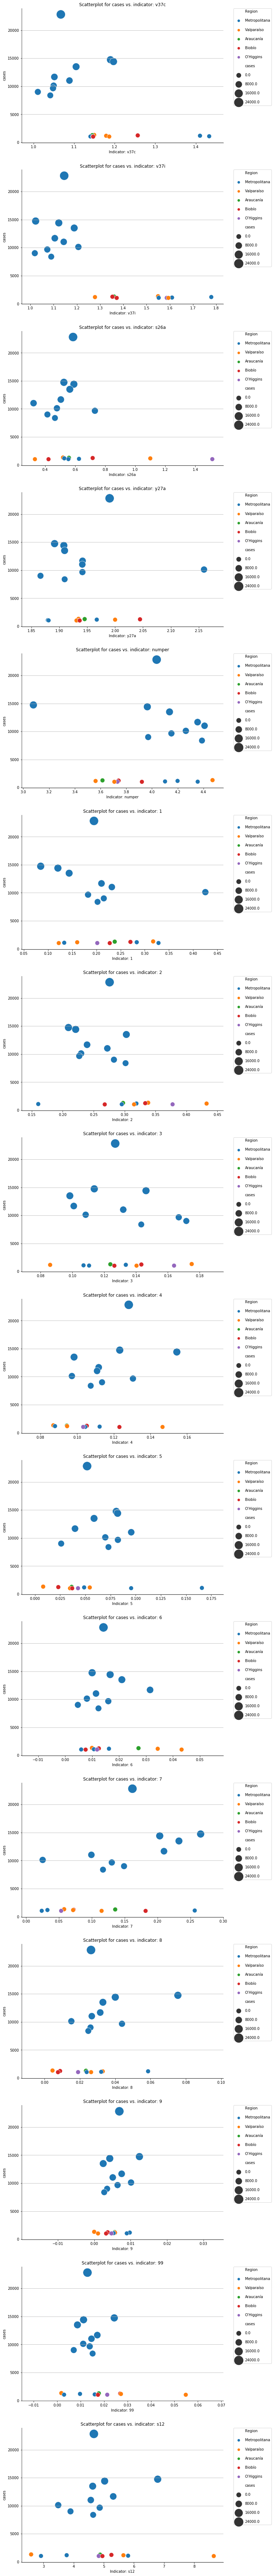

In [254]:
# To select the less affected districts, I chose a threshold of minimum 1000 cases:
plot_indicator_vs_affected(cases_districts, casen_rel_all, 'cases', 10, -10, 1000)

### B. Scatterplot for Covid-19 deaths

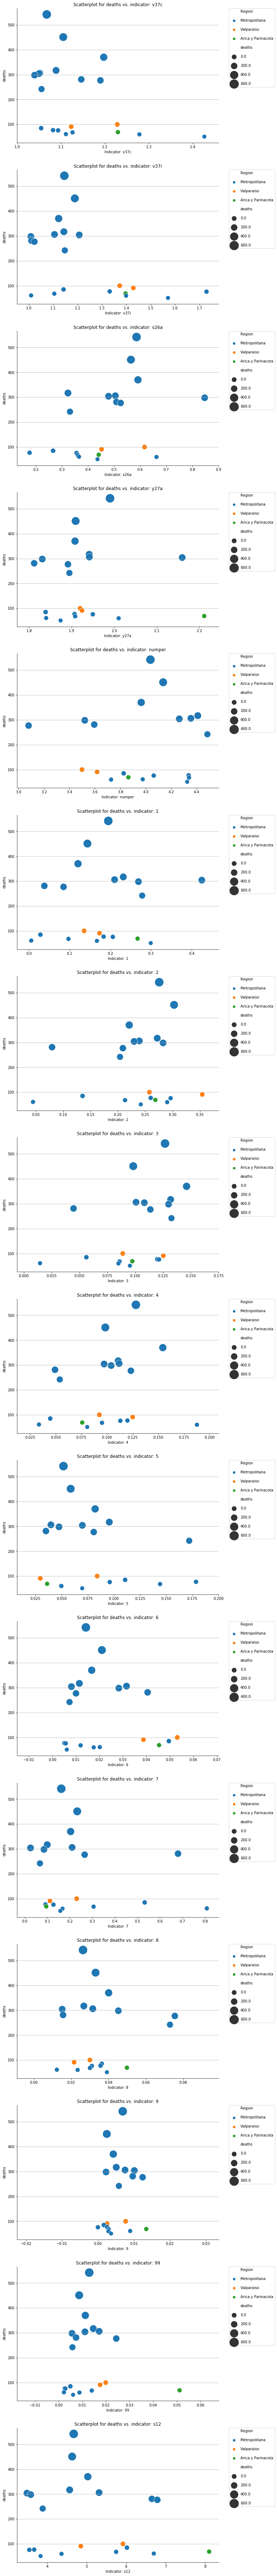

In [255]:
# To plot the deaths, I chose a threshold of 50 deaths caused by Covid-19:
plot_indicator_vs_affected(deaths_districts, casen_rel_all, 'deaths', 10, -10, 50)

## <a class="anchor" id="part-vi">Part VI: Predict Covid-19 cases/deaths applying a Machine Learning model to CASEN data</a>

[Go to index](#head)

In this part, we are going to apply a simple Machine Learning model to the CASEN data. We are going to try out the performance of KNeighborsRegressor (with different k values) and LinearRegression. 

We will compare the score values for both estimators and plot the relation between the predicted and the real values. 

In [256]:
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

def create_model(df, casen_data, title, m=0, n=1000):
    
    """
    A function to create a Machine Learning model to predict cases and deaths only based on 
    the CASEN social indicators. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districts. If m == 0, it returns a sorted DataFrame of all districts,
                 which is recommended for this function.
        n: Threshold of number of cases/deaths for districts to be considered in the less affected districts. 
           In this function we recommend n=1000
        
    Output:
        Score (float): The score of the Machine Learning model.
        coef_df (DataFrame): A sorted DataFrame with all features sorted by their coefficients. 
        A Matplotlib scatterplot of the real values vs. the predicted values.  
        
    """

    # We drop all NaNs, which takes away about 50.000 rows (of course, here are other possibilities).
    casen_data_ml = casen_data.dropna()

    # Get X and y for LinearRegression model. We also create the DataFrame z to retrieve the 'Region' data
    X = show_CASEN_for_districts(df, casen_data_ml, title, m, n).drop(['District', 'Region', title, 'comuna'], axis = 1)
    y = show_CASEN_for_districts(df, casen_data_ml, title, m, n)[title]
    z = show_CASEN_for_districts(df, casen_data_ml, title, m, n)

    # Normalize the data
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)

    # Split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
    
    # Prepare DataFrame (using z) to match every index with a region. 
    df_merge = pd.merge(pd.DataFrame(y_test), pd.DataFrame(z[z.index.isin(y_test.index)]['Region']), left_index=True, right_index=True)

    # Train KNeighborsRessor and find best k: 
    acc = []
    for k in range(1,100):
        kneigh = neighbors.KNeighborsRegressor(n_neighbors=k)
        kneigh.fit(X_train, y_train)
        kneigh_score = kneigh.score(X_test, y_test)
        acc.append(kneigh_score)
        
    # Print the score and k for the best k. 
    print('The score of KNeighborsRegressor is highest with {} at k = {}.'.format(max(acc), acc.index(max(acc)) + 1))

    # Plot the search for the best k. 
    f, ax = plt.subplots(figsize = (12,8))
    plt.plot(range(1,100), acc)
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different values of k in KNeighborsRegressor')
    
    # Fit KNeighborsRegressor with best k. 
    kneigh_opt = neighbors.KNeighborsRegressor(n_neighbors=acc.index(max(acc)) + 1)
    kneigh_opt.fit(X_train, y_train)

    # Predict test data. 
    y_predict = kneigh_opt.predict(X_test)
    
    # Plot real values vs. predicted values. 
    f, ax = plt.subplots(figsize = (12,8))
    sns.scatterplot(y_predict, df_merge[title], sizes = (100, 500), size = df_merge[title], hue = df_merge['Region'], alpha = 0.8)
    plt.title('Prediction of Covid-19 {} with KNeighborsRegressor: Comparison of predicted values vs. real values'.format(title))
    plt.xlabel('y_predict: Predicted value')
    plt.ylabel('y_test: real value')
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    
    # Train LinearRegression model and predict test values
    lr_model = LinearRegression().fit(X_train, y_train)
    y_predict= lr_model.predict(X_test)

    # Print the score for LinearRegression model
    print('The score of LinearRegression equals: {}'.format(lr_model.score(X_test, y_test)))

    # Plot scatterplot of predicted vs. true values
    f, ax = plt.subplots(figsize = (12,8))

    sns.scatterplot(y_predict, df_merge[title], sizes = (100, 500), size = df_merge[title], hue = df_merge['Region'], alpha = 0.8)
    plt.title('Prediction of Covid-19 {} with LinearRegression: Comparison of predicted values vs. real values'.format(title))
    plt.xlabel('y_predict: Predicted value')
    plt.ylabel('y_test: real value')
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



The score of KNeighborsRegressor is highest with 0.49906469673389997 at k = 11.


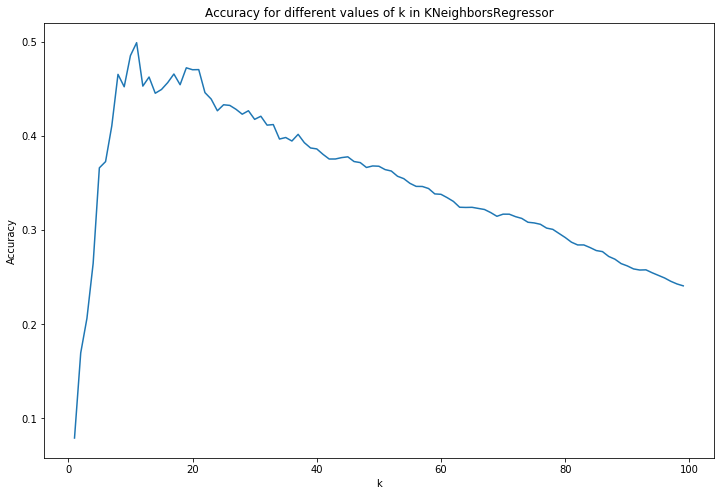

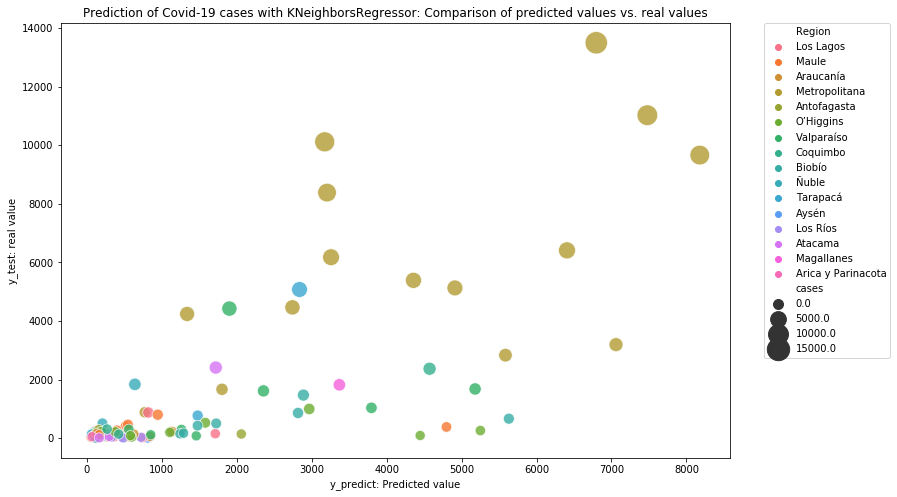

The score of LinearRegression equals: 0.3918008828626771


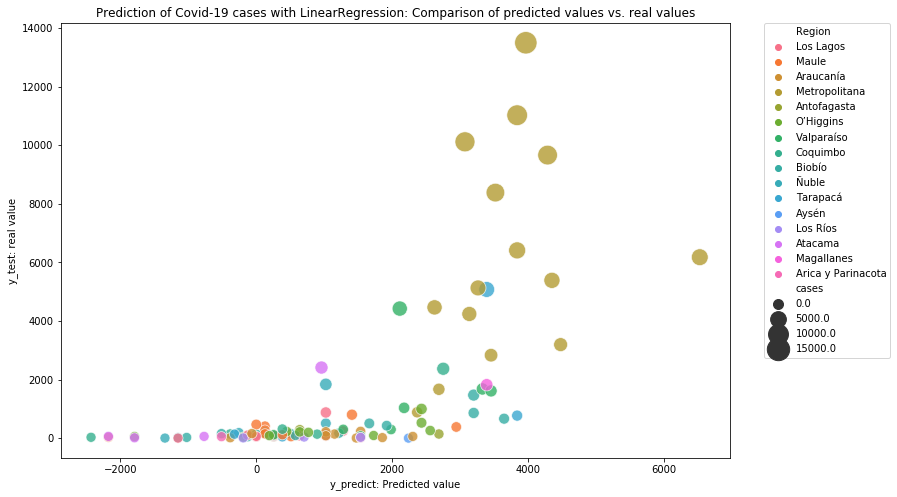

In [257]:
create_model(cases_districts, casen_rel_all, 'cases', m=0, n=1000)

The score of KNeighborsRegressor is highest with 0.6095998168396279 at k = 9.


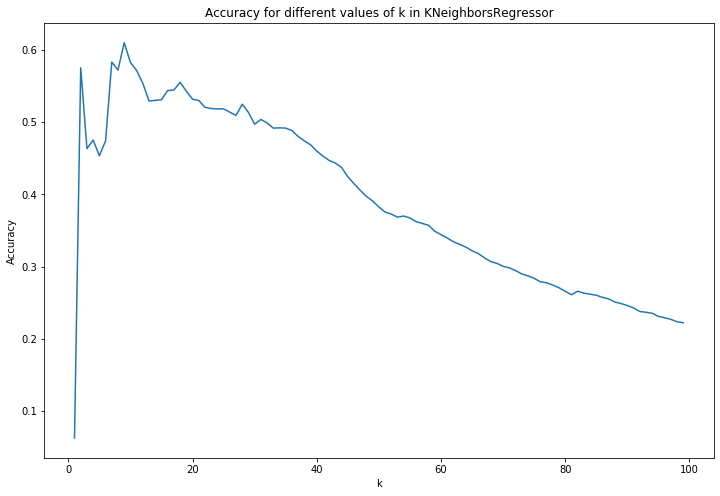

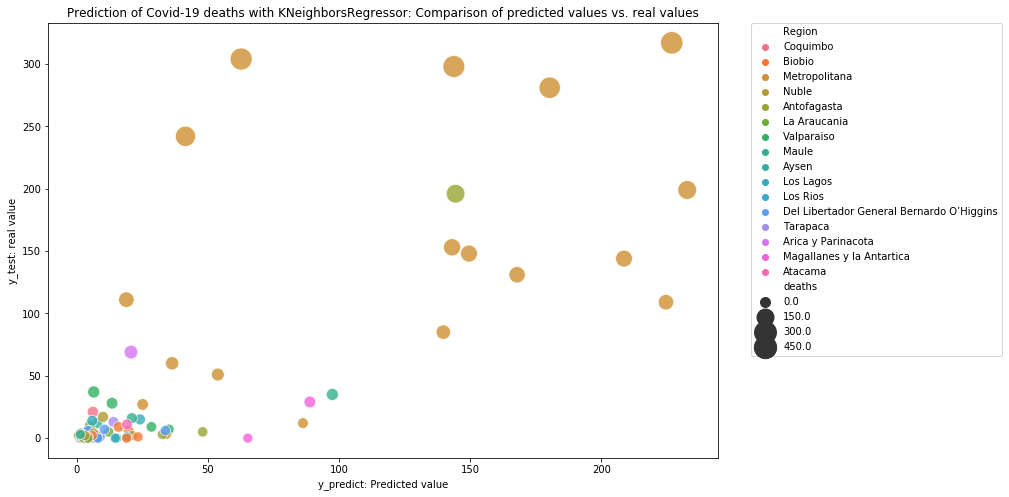

The score of LinearRegression equals: 0.4451642792769033


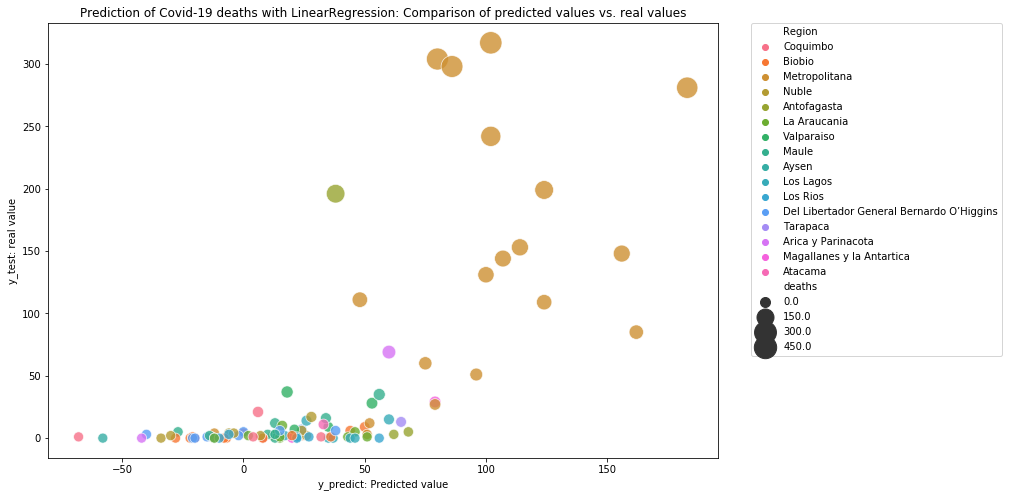

In [258]:
create_model(deaths_districts, casen_rel_all, 'deaths', m=0, n=1000)